In [30]:
from pprint import  pprint
import itertools

import torch
from torch import nn
import torchvision
import presets
import numpy as np
import calibration_utils

from torchvision.transforms.functional import InterpolationMode
from sklearn.metrics import  confusion_matrix
from matplotlib import pyplot as plt

In [31]:
device = 'cpu'
MODEL = 'mobilenet_v3_large'
NUM_CLASSES = 2
PATH = 'output/model_8.pth'

model = torchvision.models.get_model(MODEL, weights=None, num_classes=NUM_CLASSES)
state_dict = torch.load(PATH)
model.load_state_dict(state_dict['model'])
model.to(device)
None

In [32]:
args = state_dict["args"]
valdir = "data/val"
interpolation = InterpolationMode(args.interpolation)

In [33]:
preprocessing = presets.ClassificationPresetEval(
                crop_size=args.val_crop_size,
                resize_size=args.val_resize_size,
                interpolation=interpolation,
                backend=args.backend,
                use_v2=args.use_v2,
            )

dataset_test = torchvision.datasets.ImageFolder(
    valdir,
    preprocessing,
)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)
data_loader = torch.utils.data.DataLoader(
        dataset_test, batch_size=args.batch_size, sampler=test_sampler, num_workers=args.workers, pin_memory=True
    )

In [34]:
criterion = nn.CrossEntropyLoss()

conf_scores, preds, gt = list(), list(), list()
with torch.inference_mode():
    for image, target in data_loader:
        image = image.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        output = model(image)
        # loss = criterion(output, target)
        conf_scores.append(torch.nn.functional.softmax(output, dim=1))
        preds.append(torch.argmax(output, dim=1))
        gt.append(target)

In [35]:
np_gt = np.concatenate([x.numpy() for x in gt])
np_pred = np.concatenate([x.numpy() for x in preds])
np_conf = np.concatenate([x[:,0].numpy() for x in conf_scores])
print(f"Ground Truth: {np_gt.shape}\t{min(np_gt)}\t{max(np_gt)}"\
      f"\nPrediction: {np_pred.shape}\t{min(np_pred)}\t{max(np_pred)}"\
      f"\nConfidence: {np_conf.shape}\t{min(np_conf):.3f}\t{max(np_conf):.3f}")

Ground Truth: (379,)	0	1
Prediction: (379,)	0	1
Confidence: (379,)	0.000	1.000


Confusion matrix, without normalization
[[257  47]
 [ 51  24]]


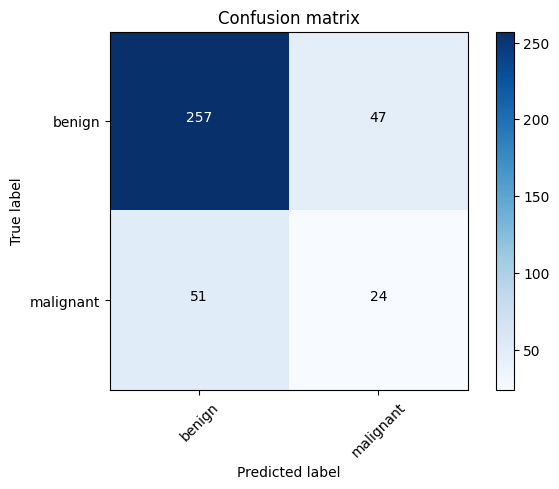

In [48]:
calibration_utils.plot_confusion_matrix(confusion_matrix(np_gt, np_pred), ["benign", "malignant"])
# pprint(confusion_matrix(np_gt, np_pred))

In [37]:
# calibration_utils.draw_reliability_graph(np_gt, np_conf)

71


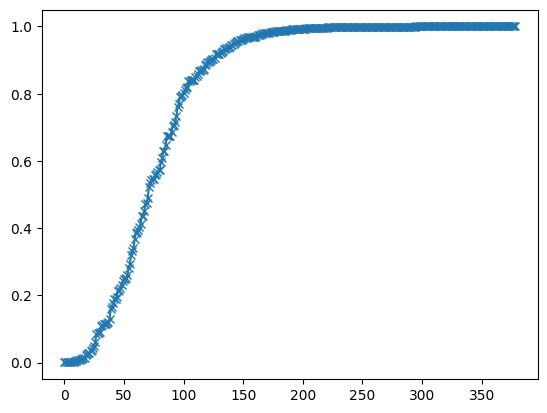

In [47]:
conf_sort = np.sort(np_conf)
print(np.sum((np_conf < 0.5)))
plt.plot(conf_sort, marker='x')
plt.show()
plt.close()

In [39]:
metrics = calibration_utils.matrix_metrix(np_gt, np_pred, 1.0)
# pprint(metrics)

In [40]:
bins, binned, bin_accs, bin_confs, bin_sizes = calibration_utils.calc_bins(np_gt, np_conf)

In [43]:
binned

array([ 9,  9,  0, 10,  9,  1,  9,  9,  9,  1,  9,  9,  8,  9,  9,  8,  0,
        9,  9,  9,  9,  9,  9,  9,  9,  0,  9,  0, 10,  9,  0,  9,  9,  9,
        5,  9, 10,  9,  9,  5,  2,  9,  0,  9,  9,  7,  9,  9,  3,  9,  9,
        8,  9,  9,  9,  5,  9,  9,  0,  6,  9,  9,  9,  9,  9, 10,  0,  0,
        9,  1,  9, 10,  9,  0,  0,  9,  9,  9,  9, 10,  1,  9,  9,  9,  6,
        9,  9,  9,  9,  9,  9,  9,  9,  5,  9,  2,  0,  9,  9,  9,  9,  9,
        6,  9,  0,  9,  9,  9,  9,  9,  9,  6,  9,  9,  4,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  2,  9,  9,  2,  9,  9,  9,  8,  9,
        9,  9,  6,  9,  0,  9,  9,  9,  9,  4,  5,  0,  9,  9,  9,  8,  9,
        9,  8,  9,  1,  8,  8,  9,  9,  9,  9,  9,  9,  8,  9,  9,  0,  9,
        9,  9,  8,  9,  9,  1,  9,  9,  0,  9,  9,  9,  7,  9,  9,  2,  9,
        5,  9,  7,  9,  9,  6,  9,  4,  0,  9,  7,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  2,  9,  3,  5,  2,  9,  9,  9,  9,  9,  7,
        9,  9,  8,  9,  9